In [78]:
'''
=============================================================================================
PROGRAMA: MODELO DE ISING EM 2D, COM CAMPO EXTERNO NULO. SIMULALÇÃO MONTE CARLO

USANDO ALGORITMO DE METROPOLIS

AUTORES: IAN DE JESUS FONTENELE LOPES/PROF. Dr. CÍCERO THIAGO GOMES DOS SANTOS, IFSERTAO-PE
=============================================================================================
'''
#============================================================================================
#                               IMPORTANDO BIBLIOTECAS
import numpy as np
from numba import njit
from math import exp
import matplotlib.pyplot as plt
import time
import seaborn as sns
#============================================================================================

#============================================================================================
#                                DEFININDO PARÂMETROS
l = 64 #dimensão da rede
num_dir = 4 #número de vizinhos
t = 1.8 #temperatura inicial
mcs = 10**6 #passo monte carlo
range_temp = 21 #faixa de temperatura
passo_temp = 0.05 #passo de temperatura
#============================================================================================

In [79]:
def inicialize_rede(L): #Cria rede de spins aleatórios
    matriz = []

    for _ in range(L):
        matriz.append([1 for i in range(L)]) # Para rede aleatória trocar 1 por: np.random.choice((1, -1))

    return matriz


@njit()
def metropolis(mcs, matriz, T, L, energia_total, magnetizacao):
    energia_autal = energia_total
    sum_energia = 0
    sum_energia_quadrada = 0
    magnetizaçao_atual = magnetizacao
    sum_magnetizaçao = 0
    sum_magnetizaçao_quadrada = 0
    for i in range(mcs): #Loop sobre o Passo Monte Carlo
        for j in range(L * L): #Loop sobre os sites
            y = np.random.choice(L) #Site aleatório
            x = np.random.choice(L) #Site aleatório
            delta_E = calcular_variação_energia(matriz, L, y, x)
            delta_M = calcular_variação_magnetizaçao(matriz, y, x)
            if delta_E > 0:
                q = np.random.random() #Número aleatório entre 0 e 1
                prob = np.exp(-delta_E/ T)
                if q < prob:
                    matriz[y][x] = (matriz[y][x]) * -1
                    energia_autal += delta_E
                    magnetizaçao_atual += delta_M
            else:
                matriz[y][x] = (matriz[y][x]) * -1
                energia_autal += delta_E
                magnetizaçao_atual += delta_M
            sum_energia += energia_autal
            sum_energia_quadrada += energia_autal * energia_autal
            sum_magnetizaçao += magnetizaçao_atual
            sum_magnetizaçao_quadrada += magnetizaçao_atual * magnetizaçao_atual
    e_m = sum_energia/(mcs * (L**2))
    e_m_q = sum_energia_quadrada/(mcs * (L**2))
    m_m = sum_magnetizaçao/(mcs * (L**2))
    m_m_q = sum_magnetizaçao_quadrada/(mcs * (L**2))
    return matriz, e_m, energia_autal, e_m_q, m_m, sum_energia, magnetizaçao_atual, m_m_q


@njit()
def calcular_variação_energia(matriz, L, y, x):
    sum_vizinhos, _ = vizinho(matriz, L, y, x)
    variacao_energia = 2 * matriz[y][x] * sum_vizinhos
    return variacao_energia


@njit()
def calcular_variação_magnetizaçao(matriz, y, x):
    variação_magnetizaçao = -2 * matriz[y][x]
    return variação_magnetizaçao


@njit()
def vizinho(matriz, L, y, x): #Condições de contorno periódica
    vizinhos = []

    vizinhos.append(matriz[y][(x+1) % L]) #primeiro vizinho da direita
    vizinhos.append(matriz[y-1][x]) # primeiro vizinho de cima
    vizinhos.append(matriz[y][x-1]) # primeiro vizinho da esquerda
    vizinhos.append(matriz[(y+1) % L][x]) #primeiro vizinho de baixo
    sum_vizinhos = 0
    for _ in range(4): #Soma sobre os vizinhos
        sum_vizinhos += vizinhos[_]
    return sum_vizinhos, vizinhos


def energia_tot(matriz, L, num_dir):
    energia_total = 0
    for y in range(L):
        for x in range(L):
            for _ in range(num_dir):
                i , vizinhos = vizinho(matriz, L, y, x)
                energia_total += (matriz[y][x] * vizinhos[_])
    energia_total = -energia_total / 2 #Dividido por 2 dois porque cada sítio é contado duas vezes
    return energia_total


def magnetizçao_total(matriz, L):
    magnetizçao = 0
    for i in range(L):
        for j in range(L):
            magnetizçao += matriz[i][j]
    return magnetizçao


"""susceptibilidade_magnetica = (magnetizçao_media_quadrada -(magnetizçao_media * magnetizçao_media))/(L * L * T) #Susceptibilidade magnética por sítio"""

#===================================================================================================================
#                                          PROGRAMA PRINCIPAL
matriz = np.array(inicialize_rede(l))
energia_total = energia_tot(matriz, l, num_dir)
magnetizcao = magnetizçao_total(matriz, l)
inicio = time.time()
matriz, _, energia_total, _, _, _, magnetizcao, _ = metropolis(mcs, matriz, t, l, energia_total, magnetizcao) #Executa o Algoritmo de Metropolis para a equilibração do sistema
print(f"metropolis demorou {time.time() - inicio:.2f} segundos")
matriz = np.array(matriz)
energia_media_ps_64 = []
m_m_ps_64 = []
calor_esp_64 = []
suscep_mag_64 = []
t_p = []
for k in range(range_temp): #Loop sobre as temperaturas
    t_p.append(t)
    matriz, e_m, energia_total, e_m_q, m_m, sum_e, magnetizcao, m_m_q = metropolis(mcs, matriz, t, l, energia_total, magnetizcao) #Executa o algoritmo para calcular as propriedades
    if t == 1.8:
        matriz_1 = np.array(matriz)
    elif t == 2.25:
        matriz_25 = np.array(matriz)
    elif t == 2.55:
        matriz_55 = np.array(matriz)
    t = round(t + passo_temp, 2)
    e = sum_e/(mcs * (l**2))
    energia_media_ps_64.append(e/(l * l))
    calor = ((e_m_q - (e_m * e_m))/( l * l * t * t))
    calor_esp_64.append(calor) #Calor específico por sítio
    m_m_ps_64.append((m_m)/(l * l))
    suscep_mag_64.append((m_m_q -(m_m * m_m))/(l * l * t))
print(energia_total)

metropolis demorou 513.32 segundos
-3612.0


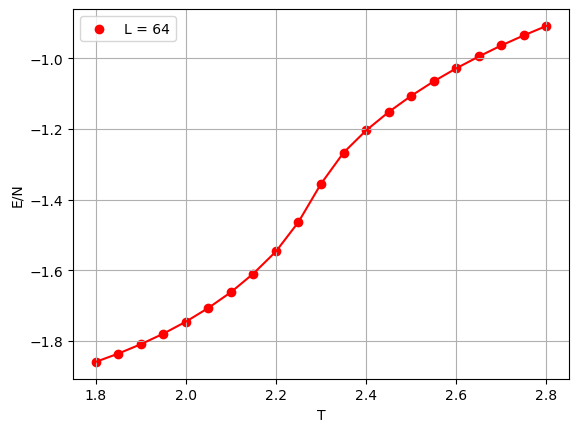

In [101]:
#plt.title('energia média por sítio em funcão da tempertura')
plt.xlabel('T')
plt.ylabel('E/N')
plt.scatter(t_p, energia_media_ps_8)
plt.plot(t_p, energia_media_ps_8)
plt.grid()
plt.legend(['L = 8'])

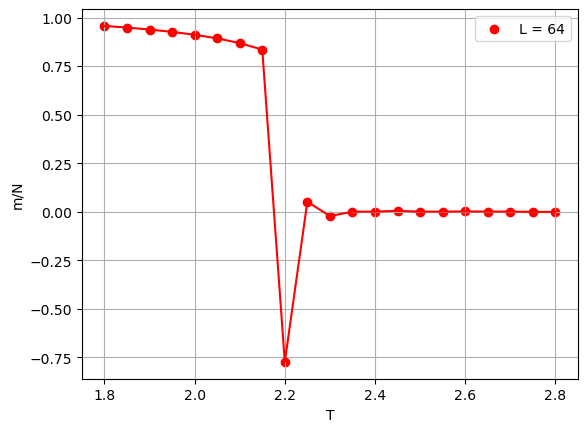

In [100]:
#plt.title('magnetização média por sítio em funcão da tempertura')
plt.xlabel('T')
plt.ylabel('m/N')
plt.scatter(t_p,m_m_ps_8)
plt.plot(t_p, m_m_ps_8)
plt.grid()
plt.legend(['L = 8'])

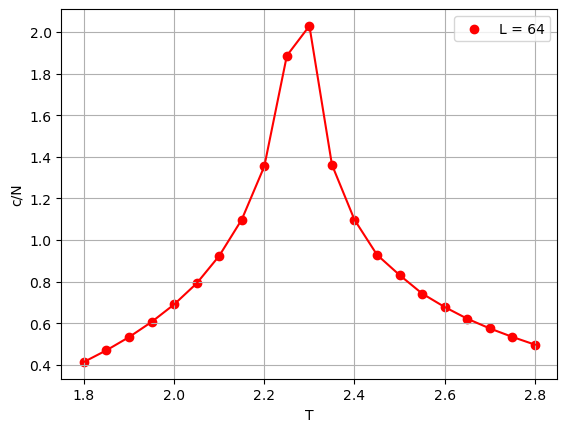

In [99]:
#plt.title('Calor especifíco por sítio em funcão da tempertura')
plt.xlabel('T')
plt.ylabel('c/N')
plt.scatter(t_p, calor_esp_8)
plt.plot(t_p, calor_esp_8)
plt.grid()
plt.legend(['L = 8'])

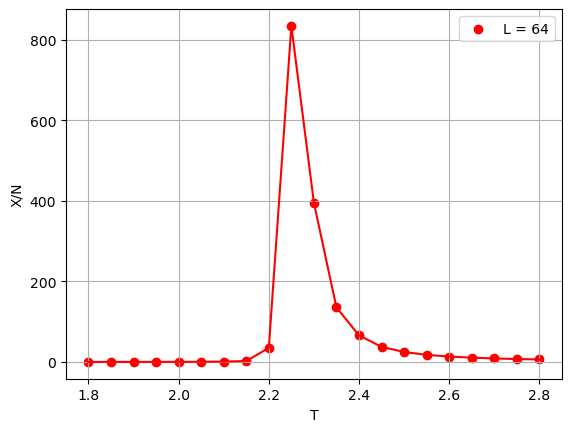

In [97]:
#plt.title('Susceptibilidade magnética média por sítio em funcão da tempertura')
plt.xlabel('T')
plt.ylabel('X/N')
plt.scatter(t_p,suscep_mag_8)
plt.plot(t_p, suscep_mag_8)
plt.grid()
plt.legend(['L = 8'])

In [17]:
energia_media_ps_8 = energia_media_ps_8

In [ ]:
energia_media_ps_16 = energia_media_ps_16

In [ ]:
#plt.title('energia média por sítio em funcão da tempertura')
plt.xlabel('T')
plt.ylabel('E/N')
plt.scatter(t_p, energia_media_ps_16, color='orange')
plt.plot(t_p, energia_media_ps_16, color='orange')
plt.grid()
plt.legend(['L = 16'])

In [48]:
energia_media_ps_32 = energia_media_ps_32

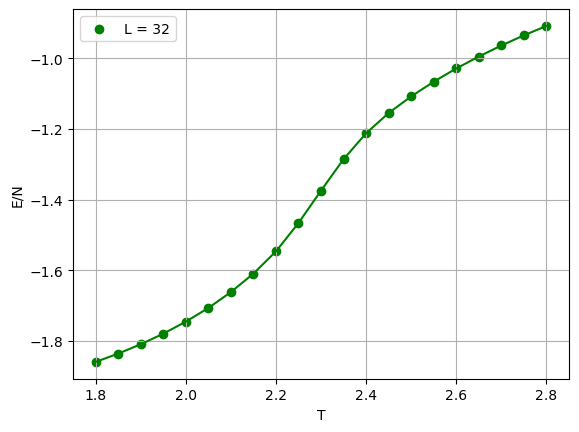

In [104]:
#plt.title('energia média por sítio em funcão da tempertura')
plt.xlabel('T')
plt.ylabel('E/N')
plt.scatter(t_p, energia_media_ps_32, color='green')
plt.plot(t_p, energia_media_ps_32, color='green')
plt.grid()
plt.legend(['L = 32'])

In [84]:
energia_media_ps_64 = energia_media_ps_64

In [16]:
m_m_ps_8 = m_m_ps_8

In [37]:
m_m_ps_16 = m_m_ps_16

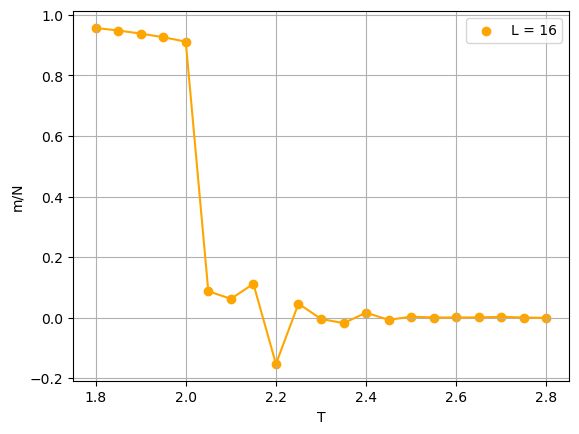

In [122]:
#plt.title('magnetização média por sítio em funcão da tempertura')
plt.xlabel('T')
plt.ylabel('m/N')
plt.scatter(t_p, m_m_ps_16, color='orange')
plt.plot(t_p, m_m_ps_16, color='orange')
plt.grid()
plt.legend(['L = 16'])

In [49]:
m_m_ps_32 = m_m_ps_32

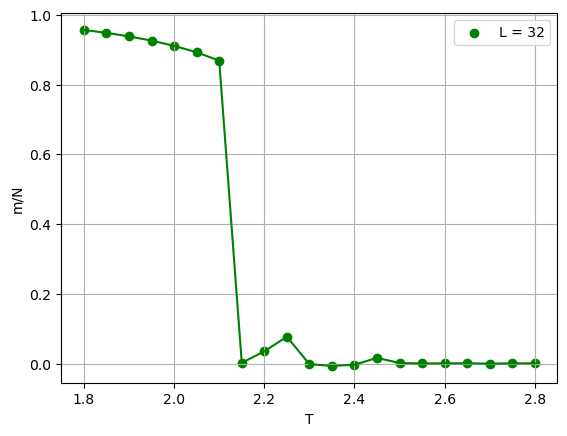

In [109]:
#plt.title('magnetização média por sítio em funcão da tempertura')
plt.xlabel('T')
plt.ylabel('m/N')
plt.scatter(t_p,m_m_ps_32, color='green')
plt.plot(t_p, m_m_ps_32, color='green')
plt.grid()
plt.legend(['L = 32'])

In [85]:
m_m_ps_64 = m_m_ps_64

In [15]:
calor_esp_8 = calor_esp_8

In [36]:
calor_esp_16 = calor_esp_16

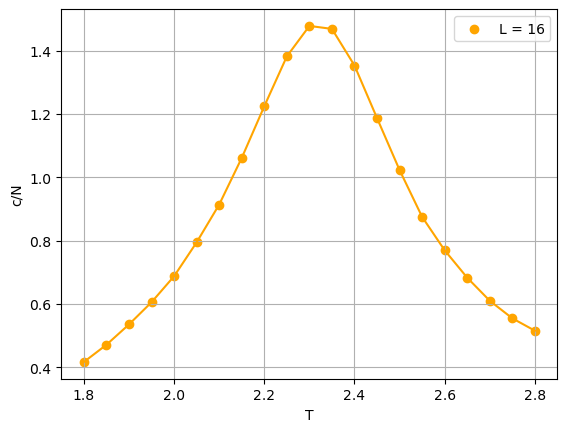

In [111]:
#plt.title('Calor especifíco por sítio em funcão da tempertura')
plt.xlabel('T')
plt.ylabel('c/N')
plt.scatter(t_p, calor_esp_16, color='orange')
plt.plot(t_p, calor_esp_16, color='orange')
plt.grid()
plt.legend(['L = 16'])

In [113]:
calor_esp_32 = calor_esp_32

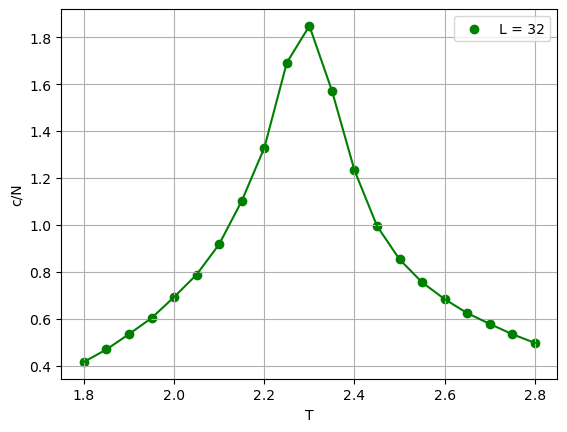

In [115]:
#plt.title('Calor especifíco por sítio em funcão da tempertura')
plt.xlabel('T')
plt.ylabel('c/N')
plt.scatter(t_p, calor_esp_32, color='green')
plt.plot(t_p, calor_esp_32, color='green')
plt.grid()
plt.legend(['L = 32'])

In [86]:
calor_esp_64 = calor_esp_64

In [14]:
suscep_mag_8 = suscep_mag_8

In [35]:
suscep_mag_16 = suscep_mag_16

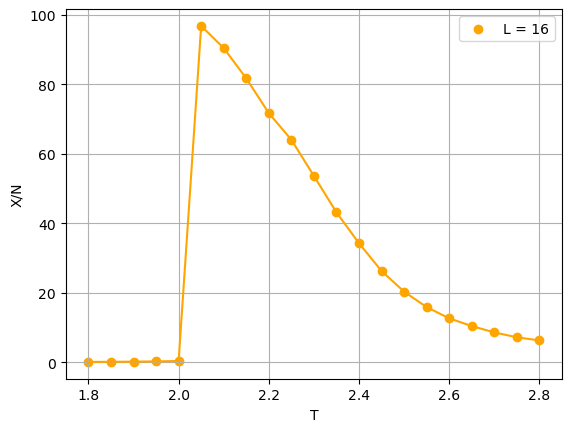

In [116]:
#plt.title('Susceptibilidade magnética média por sítio em funcão da tempertura')
plt.xlabel('T')
plt.ylabel('X/N')
plt.scatter(t_p,suscep_mag_16, color='orange')
plt.plot(t_p, suscep_mag_16, color='orange')
plt.grid()
plt.legend(['L = 16'])

In [51]:
suscep_mag_32 = suscep_mag_32

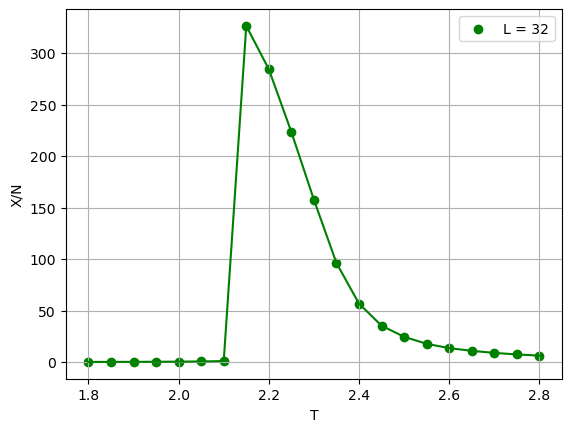

In [117]:
#plt.title('Susceptibilidade magnética média por sítio em funcão da tempertura')
plt.xlabel('T')
plt.ylabel('X/N')
plt.scatter(t_p,suscep_mag_32, color='green')
plt.plot(t_p, suscep_mag_32, color='green')
plt.grid()
plt.legend(['L = 32'])

In [87]:
suscep_mag_64 = suscep_mag_64

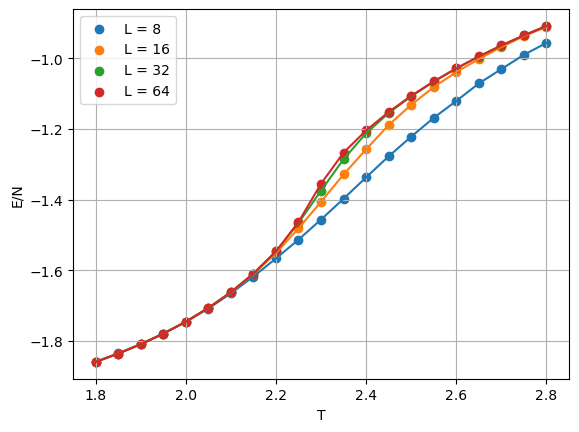

In [118]:
#plt.title('Energia média por sítio em funcão da tempertura')
plt.xlabel('T')
plt.ylabel('E/N')
plt.scatter(t_p, energia_media_ps_8)
plt.scatter(t_p, energia_media_ps_16)
plt.scatter(t_p, energia_media_ps_32)
plt.scatter(t_p, energia_media_ps_64)
plt.plot(t_p, energia_media_ps_8)
plt.plot(t_p, energia_media_ps_16)
plt.plot(t_p, energia_media_ps_32)
plt.plot(t_p, energia_media_ps_64)
plt.grid()
plt.legend(['L = 8','L = 16', 'L = 32', 'L = 64'])

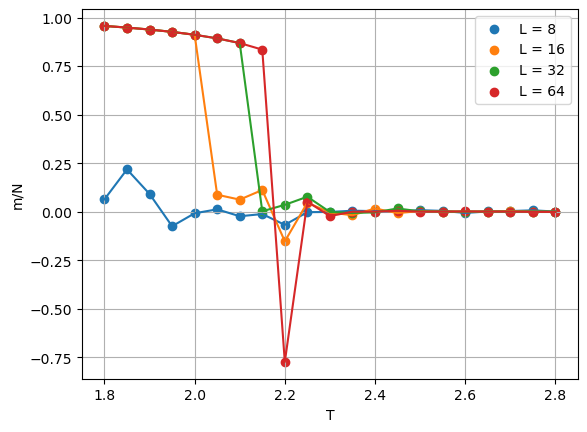

In [119]:
#plt.title('Magnetização média por sítio em funcão da tempertura')
plt.xlabel('T')
plt.ylabel('m/N')
plt.scatter(t_p, m_m_ps_8)
plt.scatter(t_p, m_m_ps_16)
plt.scatter(t_p, m_m_ps_32)
plt.scatter(t_p, m_m_ps_64)
plt.plot(t_p, m_m_ps_8)
plt.plot(t_p, m_m_ps_16)
plt.plot(t_p, m_m_ps_32)
plt.plot(t_p, m_m_ps_64)
plt.grid()
plt.legend(['L = 8','L = 16', 'L = 32', 'L = 64'])

[1.8, 1.85, 1.9, 1.95, 2.0, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8]


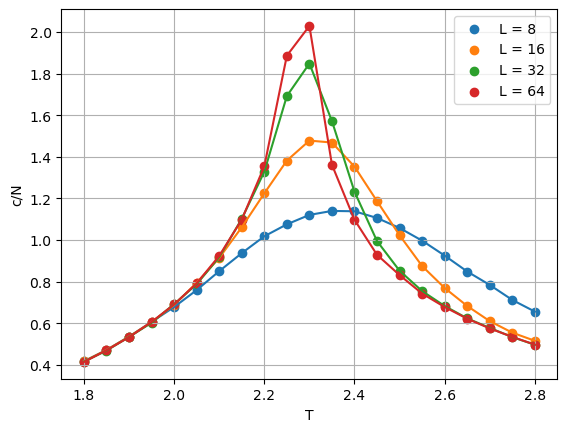

In [123]:
#plt.title('Calor especifíco por sítio em funcão da tempertura')
plt.xlabel('T')
plt.ylabel('c/N')
plt.scatter(t_p, calor_esp_8)
plt.scatter(t_p, calor_esp_16)
plt.scatter(t_p, calor_esp_32)
plt.scatter(t_p, calor_esp_64)
plt.plot(t_p, calor_esp_8)
plt.plot(t_p, calor_esp_16)
plt.plot(t_p, calor_esp_32)
plt.plot(t_p, calor_esp_64)
plt.grid()
plt.legend(['L = 8','L = 16', 'L = 32', 'L = 64'])
print(t_p)

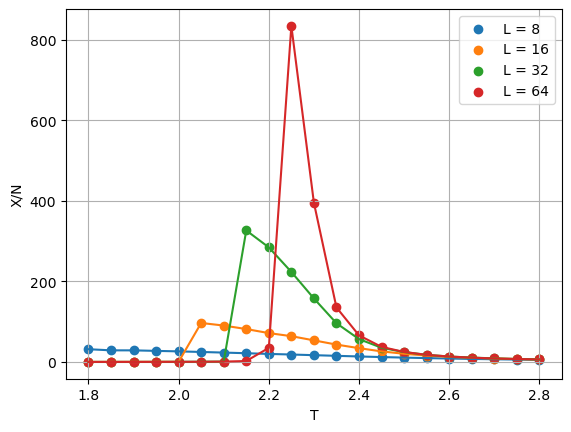

In [121]:
#plt.title('Susceptibilidade magnética média por sítio em funcão da tempertura')
plt.xlabel('T')
plt.ylabel('X/N')
plt.scatter(t_p, suscep_mag_8)
plt.scatter(t_p, suscep_mag_16)
plt.scatter(t_p, suscep_mag_32)
plt.scatter(t_p, suscep_mag_64)
plt.plot(t_p, suscep_mag_8)
plt.plot(t_p, suscep_mag_16)
plt.plot(t_p, suscep_mag_32)
plt.plot(t_p, suscep_mag_64)
plt.grid()
plt.legend(['L = 8','L = 16', 'L = 32', 'L = 64'])

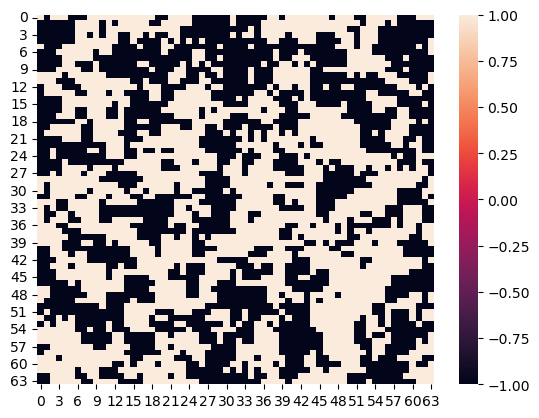

[[ 1 -1  1 ...  1  1  1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [ 1  1  1 ...  1  1  1]
 [-1 -1  1 ...  1  1  1]
 [-1 -1  1 ...  1  1  1]]


In [98]:
sns.heatmap(matriz)
plt.show()
print(matriz)

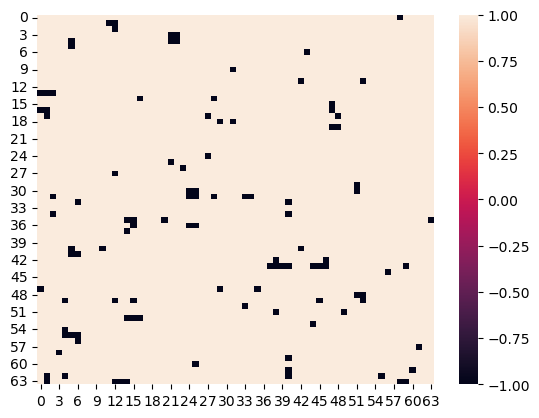

[[ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 1  1  1 ...  1  1  1]
 [ 1 -1  1 ...  1  1  1]
 [ 1 -1  1 ...  1  1  1]]


In [93]:
sns.heatmap(matriz_1)
plt.show()
print(matriz_1)

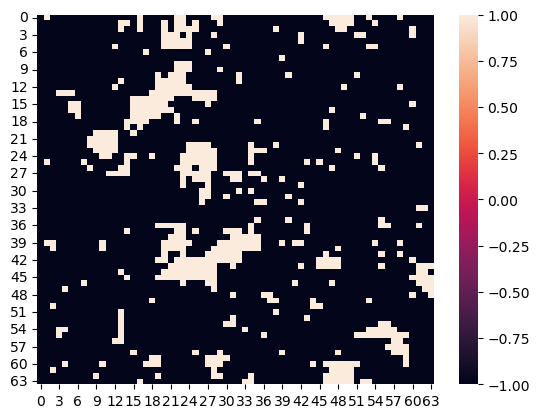

[[-1  1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1  1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


In [94]:
sns.heatmap(matriz_25)
plt.show()
matrrzt = list(matriz_25)
print(matriz_25)

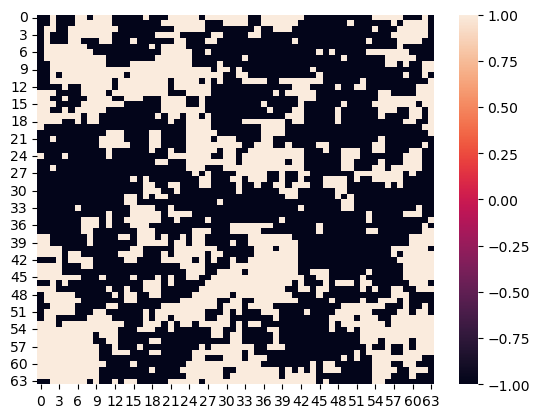

[[-1 -1  1 ... -1  1 -1]
 [-1 -1  1 ...  1  1 -1]
 [-1  1  1 ...  1  1 -1]
 ...
 [ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ... -1 -1 -1]
 [-1 -1  1 ... -1 -1 -1]]


In [95]:
sns.heatmap(matriz_55)
plt.show()
print(matriz_55)